**Group number**  
3

**Group members**  
Alexander Stoustrup  
Mathias Tyranski  
Benjamin Simonsen

In [1]:
import numpy as np
from scipy.optimize import minimize
import scipy.signal as si
import sympy as sp
import control as ct
from typing import List
from sympy.plotting import plot
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math

def eq_disp(varstring, expr, unit=""):
    display(Latex(f"${varstring}={sp.latex(expr)} \: {unit}$"))
    
def reduce_feedback(G_fwd, G_bwd):
    """Assumes feedback is deducted from signal, if not
    change sign of feedback"""
    return sp.simplify(G_fwd/(1+G_fwd*G_bwd))

def RHarray(coeffs: List):
    # first 2 rows from coefficients
    n = len(coeffs)
    arr = sp.zeros(n, n//2+2)
    i = 0
    for i in range(0,n,2):
        arr[0, i//2] = coeffs[i]
    for i in range(1,n,2):
        arr[1, i//2] = coeffs[i]

    for j in range(2, arr.shape[0]):
        for i in range(arr.shape[1]-1):
            a0 = arr[j-2,0]
            a3 = a1 = arr[j-1,i+1]
            a1 = arr[j-1,0]
            a2 = arr[j-2,i+1]
            arr[j, i] = (a1*a2-a0*a3)/a1
    return arr

# P6.8

## a)

In [2]:
K1, K2, K3, s, t = sp.symbols('K1, K2, K3, s, t')
tau1, tau3, tau4 = 0.5, 1, 1/4
Gs = K1/(tau1*s + 1)
Gd = K3/((tau3*s + 1)*(tau4*s + 1))

In [3]:
T = reduce_feedback(Gs*K2*Gd, 1)
T

K1*K2*K3/(K1*K2*K3 + (0.25*s + 1)*(0.5*s + 1)*(s + 1))

The coefficients of the characteristic equation are

In [4]:
p, q = T.as_numer_denom()
coeffs = sp.Poly(q, s).coeffs()
for i, k in enumerate(coeffs):
    display(Latex(f"${f's^{len(coeffs)-1-i}'}: {sp.latex(k)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
arr = RHarray(coeffs)
arr

Matrix([
[                                         0.125,               1.75, 0, 0],
[                                         0.875, 1.0*K1*K2*K3 + 1.0, 0, 0],
[-0.142857142857143*K1*K2*K3 + 1.60714285714286,                  0, 0, 0],
[                            1.0*K1*K2*K3 + 1.0,                  0, 0, 0]])

Now applying the Routh Hurwitz criterion to the first columnm, all coefficients should be positive, which gives the bounding equation:

In [6]:
K = sp.symbols('K', positive=True)
sol = sp.solve([arr[2, 0].subs(K1*K2*K3, K) > 0, arr[3, 0].subs(K1*K2*K3, K) > 0], K).subs(K, K1*K2*K3)
sol

K1*K2*K3 < 11.25

## b)

In [22]:
K = float(sol.rhs)/3
s = ct.tf('s')
T = K/(K+(0.25*s+1)*(0.5*s+1)*(s+1))
T

TransferFunction(array([3.75]), array([0.125, 0.875, 1.75 , 4.75 ]))

We can analyse the poles of the system to see if it can be reduced to a second order system

In [8]:
poles = T.poles()
for i, p in enumerate(poles):
    eq_disp(f'-s_{i}', np.round(p,3))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Since one poles real value is approximately 10 times larger than the others it can be neglected so we simplify to a second order system

In [9]:
T_reduced = sum(T.num[0])/np.prod([s-p for p in poles[1:]])
T_reduced

TransferFunction(array([3.75]), array([1.        +0.j, 1.28626173+0.j, 6.65063714+0.j]))

Get damping ratio and natural frequency

In [10]:
omega, zeta, _ =T_reduced.damp()
omega = omega[0]
zeta = zeta[0]
eq_disp('\omega', round(omega,3))
eq_disp('\zeta', round(zeta,3))

c:\Users\osteb\anaconda3\envs\main\lib\site-packages\control\xferfcn.py:1055: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\osteb\anaconda3\envs\main\lib\site-packages\control\xferfcn.py:1085: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The setling time at 2% threshold is calculated by:
$$
T_s=4 \tau=\frac{4}{\xi \omega_n}
$$

In [11]:
Ts = 4/(zeta*omega)
eq_disp('T_s', round(Ts,3))

<IPython.core.display.Latex object>

We see that the settling time is larger than the requirment

## c)

The value of K that meets requirements is found by plotting the setling time for a range of values of K

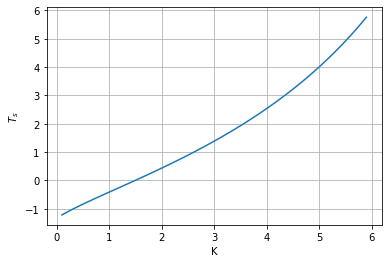

In [12]:
def Ts_f(K):
    s = ct.tf('s')
    T = K/(K+(0.25*s+1)*(0.5*s+1)*(s+1))
    poles = T.poles()
    T_reduced = sum(T.num[0])/np.prod([s-p for p in poles[1:]])
    omega, zeta, _ =T_reduced.damp()
    omega = omega[0]
    zeta = zeta[0]
    return 4/(zeta*omega)-4

Kspan = np.r_[0.1:6:0.1]
Ts_array = np.vectorize(Ts_f)(Kspan)
plt.plot(Kspan, Ts_array)
plt.xlabel('K')
plt.ylabel('$T_s$')
plt.grid()
plt.show()

The maximum value of K that still meets requirements is:

In [13]:
Kmax = Kspan[np.argmin(abs(Ts_array-4))]
eq_disp('K',round(Kmax,3))

<IPython.core.display.Latex object>

# P6.15

In [14]:
s = sp.symbols('s')
K = sp.symbols('K', positive=True)
L = K*(s**2 + 30*s + 1125)/(s*(s + 20)*(s**2 + 10*s + 125)*(s**2 + 60*s + 3400))
eq_disp('L(s)', L)

T = reduce_feedback(L,1)
eq_disp('T(s)', T)

p, q = T.as_numer_denom()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# a)

Neglecting the numerator polynomial (zeros) and the denominator polynomial $(s^2+60s+3400)$

In [15]:
La = K/(s*(s + 20)*(s**2 + 10*s + 125))
eq_disp('L(s)', La)

Ta = reduce_feedback(La,1)
eq_disp('T(s)', Ta)

pa, qa = Ta.as_numer_denom()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We get the characteristic equation with the following coefficients

In [16]:
coeffs = sp.Poly(qa, s).coeffs()
eq_disp('q(s)', sp.Poly(qa, s))
for i, k in enumerate(coeffs):
    display(Latex(f"${f's^{len(coeffs)-1-i}'}: {sp.latex(k)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Generate a Routh array

In [17]:
arr = RHarray(coeffs)
arr

Matrix([
[              1,  325, K, 0],
[             30, 2500, 0, 0],
[          725/3,    K, 0, 0],
[2500 - 18*K/145,    0, 0, 0],
[              K,    0, 0, 0]])

No change of sign in the first column so
$$K>0$$
and
$$2500 - \frac{18K}{145}>0$$

So the acceptable range of $K$ is

In [18]:
sol = sp.solve([arr[3,0] > 0, arr[4,0] > 0], K)
sol

K < 181250/9

## b)

The characteristic equation with the coefficients

In [19]:
coeffs = sp.Poly(q, s).coeffs()
eq_disp('q(s)', sp.Poly(q, s))
for i, k in enumerate(coeffs):
    display(Latex(f"${f's^{len(coeffs)-1-i}'}: {sp.latex(k)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [20]:
arr = sp.simplify(sp.N(RHarray(coeffs),3))
arr

Matrix([
[                                                                                      1.0,           5.53e+3,     K + 1.25e+6, 1.13e+3*K, 0],
[                                                                                     90.0,           1.24e+5, 30.0*K + 8.5e+6,         0, 0],
[                                                                                  4.15e+3, 0.667*K + 1.16e+6,       1.13e+3*K,         0, 0],
[                                                                       9.88e+4 - 0.0145*K,   5.59*K + 8.5e+6,               0,         0, 0],
[                               (0.00964*K**2 - 2.59e+4*K - 7.94e+10)/(0.0145*K - 9.88e+4),         1.13e+3*K,               0,         0, 0],
[(0.289*K**3 - 3.28e+6*K**2 + 1.03e+13*K - 6.75e+17)/(0.00964*K**2 - 2.59e+4*K - 7.94e+10),                 0,               0,         0, 0],
[                                                                                1.13e+3*K,                 0,               0,      

In [21]:
sol = sp.solve([arr[3,0] > 0, arr[4,0] > 0, arr[5,0] > 0, arr[6,0] > 0], K)
sp.simplify(sol)

(K < 6830328.67607119) & ((K > 4512810.08888371) | (K < 66809.2900394205)) & ((K > 6830328.67607119) | (K < 4512810.08888371))

Meaning that
$$0< K < 66809$$

# AP6.6

In [22]:
K_p, K_D = sp.symbols('K_p, K_D', positive=True)
s = sp.symbols('s')
G = 1/((s + 1)*(s + 2)*(s + 4))
G_c = K_p + K_D*s
eq_disp('G(s)', G)
eq_disp('G_c(s)', G_c)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [23]:
T = reduce_feedback(G*G_c, 1)
eq_disp('T(s)', T)

<IPython.core.display.Latex object>

In [24]:
p, q = T.as_numer_denom()
eq_disp('q(s)', sp.Poly(q, s))
coeffs = sp.Poly(q, s).coeffs()
for i, k in enumerate(coeffs):
    display(Latex(f"${f's^{len(coeffs)-1-i}'}: {sp.latex(k)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [25]:
arr = sp.simplify(RHarray(coeffs))
arr

Matrix([
[                 1, K_D + 14, 0, 0],
[                 7,  K_p + 8, 0, 0],
[K_D - K_p/7 + 90/7,        0, 0, 0],
[           K_p + 8,        0, 0, 0]])

So for the stable system the relationship between $K_p$ and $K_D$ is obtained

In [26]:
sol = sp.solve([arr[2,0] > 0, arr[3,0] > 0], K_p)
sol

K_p < 7*K_D + 90

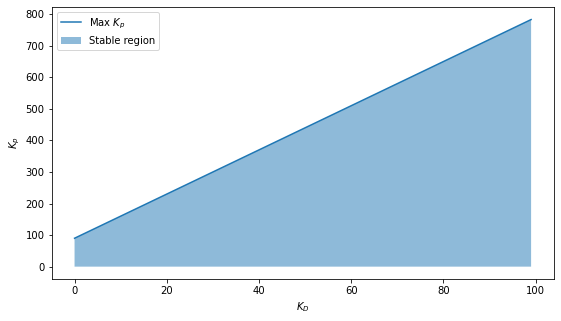

In [27]:
K_D_span = np.arange(0,100,1)

K_p_max = 7*K_D_span + 90

fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.plot(K_D_span, K_p_max)
ax1.fill_between(K_D_span, K_p_max, alpha=.5, linewidth=0)
ax1.set_xlabel('$K_D$')
ax1.set_ylabel('$K_p$')
ax1.legend(['Max $K_p$','Stable region'])

# DP6.4

In [28]:
m, K = sp.symbols('m, K', postive=True)
G_c = (s + m)*(s + 2)/s
G = K/(s**2 - 1)
T = reduce_feedback(G_c*G, 1)
eq_disp('T(s)', T)

<IPython.core.display.Latex object>

## a)

In [29]:
p, q = T.as_numer_denom()
eq_disp('q(s)', sp.Poly(q, s))
coeffs = sp.Poly(q, s).coeffs()
for i, k in enumerate(coeffs):
    display(Latex(f"${f's^{len(coeffs)-1-i}'}: {sp.latex(k)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [30]:
arr = sp.simplify(RHarray(coeffs))
arr

Matrix([
[                  1, K*m + 2*K - 1, 0, 0],
[                  K,         2*K*m, 0, 0],
[K*m + 2*K - 2*m - 1,             0, 0, 0],
[              2*K*m,             0, 0, 0]])

In [31]:
sol = sp.solve([arr[2,0] > 0, arr[3,0] > 0], K)
sol

(2*K*m > 0) & (K*(m + 2) > 2*m + 1)

So
$$ K > \frac{2m+1}{m+2}$$

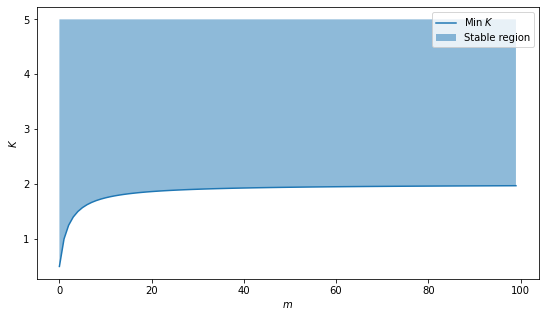

In [32]:
m_span = np.arange(0,100,1)

K_min = (2*m_span + 1)/(m_span + 2)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(m_span, K_min)
ax.fill_between(m_span, K_min, 5, alpha=.5, linewidth=0)
ax.set_xlabel('$m$')
ax.set_ylabel('$K$')
ax.legend(['Min $K$','Stable region'])

## b)

Steady state error
$$E(s) = R(s) - Y(s) = R(s) - R(s)T(s) = R(s)(1 - T(s)) $$
$$e_{ss} = \lim_{s \to 0} s E(s) = \lim_{s \to 0} s R(s)(1 - T(s))$$

The ramp input with magnitude $K_R$ is
$$R(s) = \frac{K_R}{s^2}$$

So the steady state error is

In [33]:
K_R = sp.symbols('K_R')

R = K_R/s**2

E = sp.simplify(R*(1 - T))

e_ss = sp.limit(s*E, s, 0)
eq_disp('e_{ss}', e_ss)

<IPython.core.display.Latex object>

If the steady state error is to be less than 10% of the input magnitude $K_R$

In [34]:
para = sp.symbols('para')
sol = sp.solve((e_ss - 0.1*K_R).subs(K*m, para), para)[0]

display(Latex(f'$K m > {np.abs(sp.N(sol,3))}$'))

<IPython.core.display.Latex object>

## c)

$K$ and $m$ are chosen to satisfy the condition above
$$K = 2$$
$$m = 3$$

In [35]:
Tb = T.subs([(K,2), (m,3)])
Tb

2*(s + 2)*(s + 3)/(s*(s**2 - 1) + 2*(s + 2)*(s + 3))

In [36]:
s = ct.tf('s')

Tbc = 2*(s+1)*(s+2)/(s*(s**2-1) + 2*(s+2)*(s+3))

eq_disp('T(s)', Tbc)

<IPython.core.display.Latex object>

In [37]:
omega, zeta, _ = Tbc.damp()
omega = omega[0]
zeta = zeta[0]
eq_disp('\\omega_n', round(omega,3))
eq_disp('\\zeta', round(zeta,3))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Percent overshoot is
$$P.O. = 100 e^{\frac{-\zeta \pi}{\sqrt{1-\zeta^2}}}$$

In [38]:
PO = 100*np.exp(-zeta*np.pi/(np.sqrt(1-zeta**2)))
eq_disp('P.O.', round(PO,2), '\%')

<IPython.core.display.Latex object>